# Instructions
Using SimPy, write a process simulation that includes waiting time (discrete event simulation).  You may use any topic of interest to you.  Write the simulation and all of the following in Jupyter.

Each element is worth 5 points and will be graded using the rubric shown here.

1.  State the problem and its significance.

2.  Provide a flow-chart model. 

3.  Simulate the process for the appropriate number of iterations (justify)

4.  Justify the validity of the model and discuss how you verified it.

5.  State  your conclusions/ findings from the model. 

6.  Generate appropriate graphs (more than one) to illustrate the results and provide a PowerPoint presentation to share with your colleagues.  Post this to the discussion. 

Be sure that your code works!

### 1. State the problem and its significance

The whole inspiration for this simulation idea goes all the way back to when I worked for the town planner in High School. In my hometowm of Stoneham, Massachuessetts there were some particularly awful and dangerous intersections, left turns and peculiar roads. However, there is one intersection in town that is notoriously and extraordinarily terrible. On the north side of Stoneham the intersection of North Street and Main Street sets up a unique opportunity for crashes. On the Main Street there are entrances and exits to one of the busiest highways in the state (i95) and North Street is one of the most popular streets to get to surrounding towns, so it also receives a lot of traffic from the highways.

When I worked for the town planner this was deemed one of the most dangerous intersections both in town and in the surrounding towns. I have always been interested in this, experiencing first-hand how truly awful it is.

### Load initial packages

In [5]:
from modsim import *
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import simpy as sp


### 2.  Provide a flow-chart model.

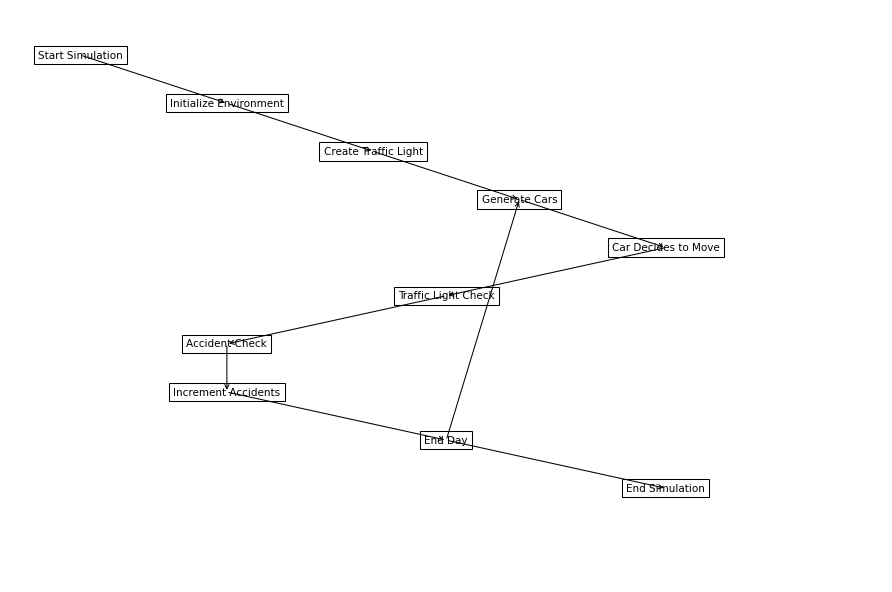

In [6]:
import matplotlib.pyplot as plt

def draw_arrow(ax, start, end):
    """Draws an arrow from start to end on the given axes."""
    ax.annotate("", xy=end, xycoords='data', xytext=start, textcoords='data',
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

def setup_figure():
    """Sets up the matplotlib figure and axes."""
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_xlim(0, 12)
    ax.set_ylim(0, 12)
    ax.axis('off')
    return fig, ax

def draw_nodes(ax, nodes):
    """Draws nodes on the given axes."""
    for node, (x, y) in nodes.items():
        ax.text(x, y, node, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black'))

def draw_edges(ax, nodes, edges):
    """Draws edges between nodes on the given axes."""
    for start, end in edges:
        start_pos, end_pos = nodes[start], nodes[end]
        draw_arrow(ax, start_pos, end_pos)

# Main code
if __name__ == "__main__":
    # Setup figure
    fig, ax = setup_figure()

    # Define nodes and their positions
    nodes = {
        'Start Simulation': (1, 11),
        'Initialize Environment': (3, 10),
        'Create Traffic Light': (5, 9),
        'Generate Cars': (7, 8),
        'Car Decides to Move': (9, 7),
        'Traffic Light Check': (6, 6),
        'Accident Check': (3, 5),
        'Increment Accidents': (3, 4),
        'End Day': (6, 3),
        'End Simulation': (9, 2)
    }

    # Define edges between nodes
    edges = [
        ('Start Simulation', 'Initialize Environment'),
        ('Initialize Environment', 'Create Traffic Light'),
        ('Create Traffic Light', 'Generate Cars'),
        ('Generate Cars', 'Car Decides to Move'),
        ('Car Decides to Move', 'Traffic Light Check'),
        ('Traffic Light Check', 'Accident Check'),
        ('Accident Check', 'Increment Accidents'),
        ('Increment Accidents', 'End Day'),
        ('End Day', 'Generate Cars'),
        ('End Day', 'End Simulation')
    ]

    # Draw nodes and edges
    draw_nodes(ax, nodes)
    draw_edges(ax, nodes, edges)

    # Display the flowchart
    plt.tight_layout()
    plt.show()

### What happens if this intersection is signalized (meaning a left turn light, specifically on either side of main street and north street)
* A study from the Department of Transportation showed that signalizing both sides of a major road for left turns has an estimated reduction in all collisions of 62% and suggests it could be even more depending on the specific area.
* While they used a more advanced model to show this, it should still apply well to my simulation.

So lets see what happens to the seasonal simulation when the probabiity of a crash at any time is reduced 62%

### 3.  Simulate the process for the appropriate number of iterations (justify)

Setting up the simulation enviornment
* I want to look at this over a year so I will be have 365 days in the simulation. There are around 9700 households in Stoneham(rounded up for ease) and probably all of them have at least one car.
* While that area is extremely busy, not everyone passes through it every day, so I wanted to weigh the TOTAL_TRIPS to figure that probably only 30% of drivers are likely to go through that intersection per day.
* Lastly, based on the research paper by the Department of Transportation I will have an improvement rate piece that lowers the base accident rate making it 62% safer with the addition of left turn lights on both sides of the road

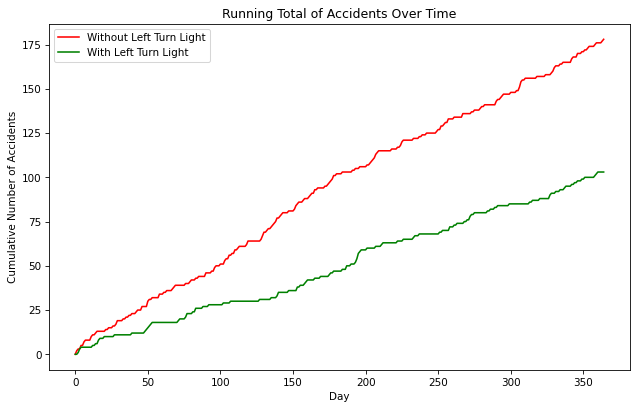

In [9]:
import simpy
import pandas as pd
import matplotlib.pyplot as plt
import random

# Initial variables
DAYS_IN_SIMULATION = 365
HOUSEHOLDS = 9700
TRIPS_PER_DAY_PER_HOUSEHOLD = 2
IMPROVEMENT_RATE = 0.32
BASE_ACCIDENT_RATE = 0.0001  
TRIP_LIMIT = 0.30  #chance of leaving the house and going through the intersection
TOTAL_TRIPS = HOUSEHOLDS * TRIPS_PER_DAY_PER_HOUSEHOLD * DAYS_IN_SIMULATION
SIMULATION_TIME = DAYS_IN_SIMULATION * 24 * 60 * 60

class TrafficLight:
    def __init__(self, env, has_left_turn_light):
        self.env = env
        self.has_left_turn_light = has_left_turn_light
        self.accidents = 0
        self.daily_accidents = [0] * DAYS_IN_SIMULATION  #Daily accident tracher I added for visualization purposes later

    def pass_through(self, current_day):
        accident_prob = BASE_ACCIDENT_RATE
        if self.has_left_turn_light:
            accident_prob *= (1 - IMPROVEMENT_RATE)
        if random.random() < accident_prob:
            self.accidents += 1
            self.daily_accidents[current_day] += 1  # Increment today's accidents

def car(env, traffic_light, current_day):
    # Simulate the 30% chance of leaving the house and going through the intersection
    if random.random() <= TRIP_LIMIT:
        traffic_light.pass_through(current_day)
    yield env.timeout(random.randint(1, 10))

def run_simulation(has_left_turn_light):
    env = simpy.Environment()
    traffic_light = TrafficLight(env, has_left_turn_light)

    def generate_cars(env, traffic_light):
        current_day = 0
        for _ in range(int(TOTAL_TRIPS)):
            if env.now >= (current_day + 1) * 24 * 60 * 60:
                current_day += 1  # Move to the next day
            yield env.timeout(random.randint(1, 10))
            env.process(car(env, traffic_light, current_day))

    env.process(generate_cars(env, traffic_light))
    env.run(until=SIMULATION_TIME)
    return traffic_light.daily_accidents

# Run simulations and calculate running total of accidents
accidents_without_left_turn_light = run_simulation(False)
accidents_with_left_turn_light = run_simulation(True)

# Calculate running totals
running_total_without = pd.Series(accidents_without_left_turn_light).cumsum()
running_total_with = pd.Series(accidents_with_left_turn_light).cumsum()

plt.figure(figsize=(10, 6))
plt.plot(running_total_without, label='Without Left Turn Light', color='red')
plt.plot(running_total_with, label='With Left Turn Light', color='green')
plt.ylabel('Cumulative Number of Accidents')
plt.xlabel('Day')
plt.title('Running Total of Accidents Over Time')
plt.legend()
plt.show()

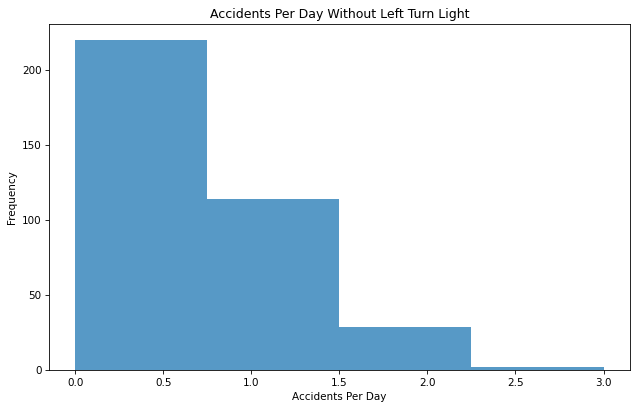

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
plt.figure(figsize=(10, 6))
no_light_df = pd.DataFrame(accidents_without_left_turn_light, columns=['accidents_without_left_turn_light'])
# Create the histogram
plt.hist(no_light_df['accidents_without_left_turn_light'], bins=4, alpha=0.75)
plt.xlabel('Accidents Per Day')
plt.ylabel('Frequency')
plt.title('Accidents Per Day Without Left Turn Light')

# Display the plot
plt.show()

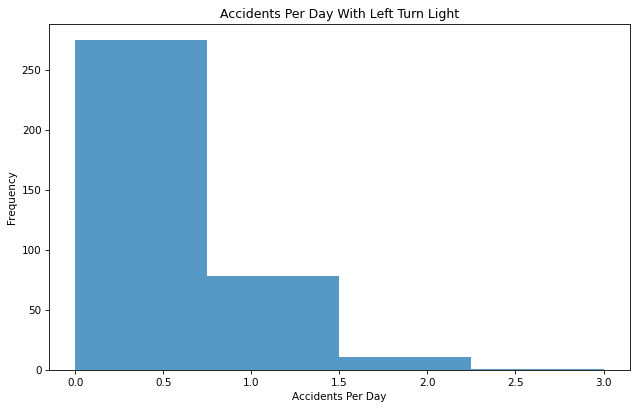

In [20]:

no_light_df = pd.DataFrame(accidents_without_left_turn_light, columns=['accidents_without_left_turn_light'])
light_df = pd.DataFrame(accidents_with_left_turn_light, columns=['accidents_with_left_turn_light'])
plt.figure(figsize=(10, 6))
plt.hist(light_df['accidents_with_left_turn_light'], bins=4, alpha=0.75)

plt.xlabel('Accidents Per Day')
plt.ylabel('Frequency')
plt.title('Accidents Per Day With Left Turn Light')

plt.show()

### 4.  Justify the validity of the model and discuss how you verified it.

The crux of the issue is there really isnt much accessible data about this intersection however I did find a dashboard on Mass.gov which looks at types of crashes and where they were reported. According to their breakdown there were 150 crashes at the intersection of North Border Road and Main Street (Route 28), both of these do not have left turn lights. So my simulation of 175 crashes at this intersection because of no left turn lights was pretty close. While its not perfect I can argue that the assumptions of my simulation are fairly sound and that the Mass DOT data, to an extent validates the simulated findings of crashes because of no left turn light.

### 5.  State  your conclusions/ findings from the model. 
* The simulation generated some interesting and promising results for the intersection of North Border Road and Main Street in Stoneham. Without the installation it is expected that there will be around 175 crashes as a result. With the installation of left turn lights, there is estimated to be 54 more days with no crashes during the year because of this. Note that these are just car crashes without any fatalities or serious injuries attatched to them.
* Driving by this intersection a countless amount of times, it still baffles me that any saftey measure hasnt been installed. The reality is, there is a very real chance that someone within the year gets injured or fatally hurt in this intersection, proposing left turn lights could limit the chance of this happening multifold.

Further research:
I realize that there is still a lot of work that could be put into this model that would make it more dynamic. One piece I considered adding was a control for seasonality since Massachuessetts winters make it far more dangerous to drive. Another piece for further research could be looking into peak traffic times, where the morning and evening commutes raise your likelyhood of being in a car crash.

Sources: 
* https://www.fhwa.dot.gov/publications/research/safety/04091/12.cfm
* https://www.point2homes.com/US/Neighborhood/MA/Stoneham-Demographics.html (approximate Stoneham Mass Demographics)
* https://apps.impact.dot.state.ma.us/cdp/dashboard-view/26